In [2]:
import torch

from torch.nn import Module, Embedding, Linear, ModuleList
from einops import rearrange, reduce, repeat
from utils.components import TransformerBlock, ConditionalLayerNorm, GatedFFN, Attention

from dataclasses import dataclass
from typing import Optional

from utils.multimodal import ModalMTM, ModalTailMTM, ModalFuncMTM
from utils.loss_fn import f_kernel_crps

from torch import autocast

In [3]:
from torch.profiler import profile, record_function, ProfilerActivity
import time

In [4]:
# Set backend preference if possible:
torch.backends.cuda.enable_flash_sdp(True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.init import trunc_normal_

In [24]:
rate = torch.empty((100000,))
rate = trunc_normal_(rate, 0.1, 0.1, 0.01, 0.4)


(array([3518., 3670., 4038., 4279., 4462., 4528., 4710., 4814., 4878.,
        4725., 4879., 4750., 4527., 4441., 4261., 3922., 3701., 3523.,
        3092., 2762., 2539., 2231., 2007., 1694., 1461., 1246., 1058.,
         887.,  738.,  604.,  525.,  413.,  304.,  246.,  176.,  137.,
         107.,   90.,   57.]),
 array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]),
 <BarContainer object of 39 artists>)

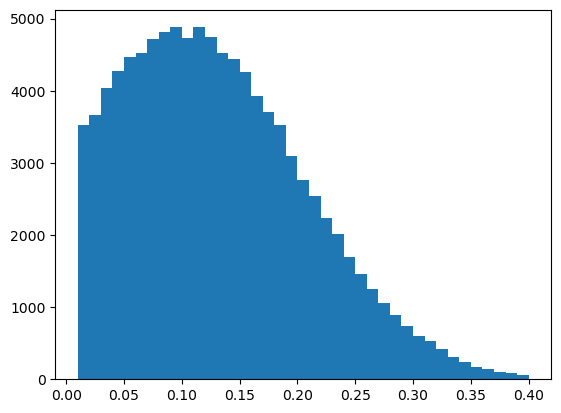

In [27]:
plt.hist(rate, bins = np.linspace(0.01, 0.4, 40))
#plt.yscale('log')

In [5]:
def predict_ambient_src(self, src, tgt, latents, ctx):
    # O(2*z*(src+tgt) + z**2)
    x = torch.cat([src, tgt], dim = 1)
    for block in self.network:
        x, z = block(x = x, z = latents, ctx = ctx)
    _, tgt = x.split([src.size(1), tgt.size(1)], dim = 1)
    return tgt, z

def predict_latent_src(self, src, tgt, latents, ctx):
    #O(2*tgt*(src + z) + (src * z)**2)
    z = torch.cat([src, latents], dim = 1)
    for block in self.network:
        tgt, z = block(x = tgt, z = z, ctx = ctx)
    _, z = z.split([src.size(1), latents.size(1)], dim=1)
    return tgt, z

def predict_self_vit(self, src, tgt, latents, ctx):
    x = torch.cat([src, latents], dim = 1)
    encoder, decoder = self.network[:-1], self.network[-1]
    for block in encoder:
        x, _ = block(x, x, ctx)
    q = torch.cat([x, tgt], dim = 1)
    q = decoder(q, q, ctx)
    _, tgt = q.split([x.size(1), tgt.size(1)], dim = 1)
    return tgt, None

def predict_cross_vit(self, src, tgt, latents, ctx):
    x = torch.cat([src, latents], dim = 1)
    encoder, decoder = self.network[:-1], self.network[-1]
    for block in encoder:
        x, _ = block(x, x, ctx)
    tgt = decoder(tgt, x, ctx)
    return tgt, None

def predict_perceiver(self, src, tgt, latents, ctx):
    encoder, decoder = self.network[:-1], self.network[-1]
    for block in encoder:
        _, z = block(src, latents, ctx)
    tgt = decoder(tgt, z, ctx)
    return tgt, None

def forward(self, src, src_pos, tgt_pos, ctx = None):  
        #initialize context
        ctx = self.proj_noise(ctx if ctx is not None else src.new_zeros(self.dim_ctx))
        # initialize src
        src = self.proj_in(src) + self.positions(src_pos)
        # initialize latents
        latents = repeat(self.latents.weight, "z d -> b z d", b = src.size(0))      
        # initialize tgt
        tgt = self.queries(torch.zeros_like(tgt_pos)) + self.positions(tgt_pos)
        # predict
        tgt, _ = self.predict_latent_src(src, tgt, latents, ctx)
        # project out
        tgt = self.proj_out(tgt)
        return tgt

In [6]:
@dataclass
class Config:
    dim_in: int
    dim_out: int
    dim: int
    num_features: Optional[int] = None
    num_tokens: Optional[int] = None
    num_compute_blocks: Optional[int] = None
    num_layers: Optional[int] = None
    num_latents: Optional[int] = None
    num_cls: Optional[int] = None
    dim_heads: int = 64
    dim_ctx: int = 8
    architecture: str = "interface"

In [7]:
B, N, F, C = 16, 4096, 73, 4
D = 512
K = 4
M_src, M_tgt, F_src, F_tgt = 512, 1024, 32, 64 

In [8]:
modal_cfg = Config(C, C, D, F, N)
interface_cfg = Config(D, D, D, None, N, 4, 6, 64)

In [9]:
model = ModalFuncMTM(mtm_cfg=interface_cfg, modal_cfg=modal_cfg).to(device)

compiled = torch.compile(
    model, 
    fullgraph=False,
    dynamic=True,
    disable=False
    )

optim = torch.optim.AdamW(compiled.parameters())
print(f'{sum(p.numel() for p in compiled.parameters()):,}') 

def step():
    with autocast(device, torch.float16):
        M_src = torch.randint(64, 512, (1,), device=device).item()
        M_tgt = torch.randint(768, 1280,(1,), device= device).item()
        F_src = torch.randint(16, 32,(1,), device=device).item()
        F_tgt = torch.randint(32, 64,(1,), device= device).item()

        pos_src = torch.multinomial(torch.ones((B, N), device = device), M_src)
        pos_tgt = torch.multinomial(torch.ones((B, N), device = device), M_tgt)
        var_src = torch.multinomial(torch.ones((B, F), device = device), F_src)
        var_tgt = torch.multinomial(torch.ones((B, F), device = device), F_tgt)
        
        noise = torch.randn((K * B, 1, 8), device = device)

        y = torch.randn((B, M_tgt, F_tgt, C), device = device)
        x = torch.randn((B, M_src, F_src, C), device = device)
        
        x_hat = compiled(x, pos_src = pos_src, pos_tgt = pos_tgt, var_src= var_src, var_tgt=var_tgt, noise=noise)
        loss = f_kernel_crps(y, x_hat).mean()
        
    optim.zero_grad()
    loss.backward()
    optim.step()
    

AttributeError: 'Config' object has no attribute 'dim_noise'

In [ ]:
start = time.time()
torch.cuda.reset_peak_memory_stats(device)
for _ in range(100):
    step()
elapsed = time.time() - start
peak_alloc = torch.cuda.max_memory_allocated(device) / (1024**3)

print(f"  • 100‑run time     : {elapsed:.4f} s")
print(f"  • Peak VRAM (100 runs): {peak_alloc:.1f} GB")

  • 100‑run time     : 37.7447 s
  • Peak VRAM (100 runs): 28.2 GB


In [ ]:
model = ModalTailMTM(mtm_cfg=interface_cfg, modal_cfg=modal_cfg).to(device)

compiled = torch.compile(
    model, 
    fullgraph=False,
    dynamic=True,
    disable=False
    )

optim = torch.optim.AdamW(compiled.parameters())
print(f'{sum(p.numel() for p in compiled.parameters()):,}') 

def step():
    with autocast(device, torch.float16):
        M_src = torch.randint(64, 512, (1,), device=device).item()
        M_tgt = torch.randint(768, 1280,(1,), device= device).item()
        F_src = torch.randint(16, 32,(1,), device=device).item()
        F_tgt = torch.randint(32, 64,(1,), device= device).item()

        pos_src = torch.multinomial(torch.ones((B, N), device = device), M_src)
        pos_tgt = torch.multinomial(torch.ones((B, N), device = device), M_tgt)
        var_src = torch.multinomial(torch.ones((B, F), device = device), F_src)
        var_tgt = torch.multinomial(torch.ones((B, F), device = device), F_tgt)
        
        noise = torch.randn((K * B, 1, 8), device = device)

        y = torch.randn((B, M_tgt, F_tgt, C), device = device)
        x = torch.randn((B, M_src, F_src, C), device = device)
        
        x_hat = compiled(x, pos_src = pos_src, pos_tgt = pos_tgt, var_src= var_src, var_tgt=var_tgt, noise=noise)
        loss = f_kernel_crps(y, x_hat).mean()
        
    optim.zero_grad()
    loss.backward()
    optim.step()


NameError: name 'ModalTailMTM' is not defined

In [11]:
start = time.time()
torch.cuda.reset_peak_memory_stats(device)
for _ in range(100):
    step()
elapsed = time.time() - start
peak_alloc = torch.cuda.max_memory_allocated(device) / (1024**3)

print(f"  • 100‑run time     : {elapsed:.4f} s")
print(f"  • Peak VRAM (100 runs): {peak_alloc:.1f} GB")

  • 100‑run time     : 14.4890 s
  • Peak VRAM (100 runs): 8.7 GB


In [12]:
model = ModalMTM(mtm_cfg=interface_cfg, modal_cfg=modal_cfg.__replace__(dim_out=C*K)).to(device)

compiled = torch.compile(
    model, 
    fullgraph=False,
    dynamic=True,
    disable=True
    )

optim = torch.optim.AdamW(compiled.parameters())
print(f'{sum(p.numel() for p in compiled.parameters()):,}') 

def step():
    with autocast(device, torch.float16):
        M_src = torch.randint(64, 512, (1,), device=device).item()
        M_tgt = torch.randint(768, 1280,(1,), device= device).item()
        F_src = torch.randint(16, 32,(1,), device=device).item()
        F_tgt = torch.randint(32, 64,(1,), device= device).item()

        pos_src = torch.multinomial(torch.ones((B, N), device = device), M_src)
        pos_tgt = torch.multinomial(torch.ones((B, N), device = device), M_tgt)
        var_src = torch.multinomial(torch.ones((B, F), device = device), F_src)
        var_tgt = torch.multinomial(torch.ones((B, F), device = device), F_tgt)
        
        y = torch.randn((B, M_tgt, F_tgt, C), device = device)
        x = torch.randn((B, M_src, F_src, C), device = device)
        
        x_hat = compiled(x, pos_src = pos_src, pos_tgt = pos_tgt, var_src= var_src, var_tgt=var_tgt)
        x_hat = rearrange(x_hat, '... (c k) -> ... c k', k = K)
        loss = f_kernel_crps(y, x_hat).mean()
        
    optim.zero_grad()
    loss.backward()
    optim.step()
    

102,783,488


In [13]:
start = time.time()
torch.cuda.reset_peak_memory_stats(device)
for _ in range(100):
    step()
elapsed = time.time() - start
peak_alloc = torch.cuda.max_memory_allocated(device) / (1024**3)

print(f"  • 100‑run time     : {elapsed:.4f} s")
print(f"  • Peak VRAM (100 runs): {peak_alloc:.1f} GB")

  • 100‑run time     : 13.9080 s
  • Peak VRAM (100 runs): 8.2 GB


In [ ]:
with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True,
        record_shapes=False,      # ← turn OFF shape logging
        with_stack=False,         # ← turn OFF call‐stack
        schedule=torch.profiler.schedule(wait=0, warmup=1, active=50, repeat=0)
    ) as prof:
        for _ in range(50):
            step()
            prof.step()


print("  • torch.profiler summary:")
print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))


  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Torch-Compiled Region: 0/0         0.24%      34.862ms        15.42%        2.262s      46.156ms       0.000us         0.00%        2.477s      50.547ms      28.33 Kb           0 

In [ ]:
big ambient

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 30.0844 s
  • Peak VRAM (100 runs): 23996.4 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.89%       4.803ms         3.23%      17.426ms      38.812us      44.582

In [ ]:
ambient src

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 21.2701 s
  • Peak VRAM (100 runs): 17726.2 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.42%       2.006ms         3.14%      14.888ms      78.775us      32.266

In [105]:
latent src

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 25.7852 s
  • Peak VRAM (100 runs): 20819.7 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.35%       2.006ms         3.09%      17.784ms      94.096us      40.035

In [ ]:
self vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 24.6475 s
  • Peak VRAM (100 runs): 19914.6 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.45%       2.418ms         3.90%      21.074ms     101.808us      37.754

In [ ]:
cross vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 24.0923 s
  • Peak VRAM (100 runs): 19592.8 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.41%       2.170ms         2.63%      13.929ms      67.290us      36.885

In [ ]:
perceiver

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 7.4787 s
  • Peak VRAM (100 runs): 6439.1 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         1.38%       1.955ms         3.99%       5.643ms      29.544us       4.105ms

In [ ]:
cross vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 10.4159 s
  • Peak VRAM (100 runs): 7261.3 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.98%       2.128ms         2.31%       5.002ms      24.761us       5.063m

In [39]:
self vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 18.4837 s
  • Peak VRAM (100 runs): 8789.8 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.55%       2.124ms         5.08%      19.593ms      96.993us       8.241m

In [ ]:
ambient src

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 8.9925 s
  • Peak VRAM (100 runs): 3137.7 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         1.19%       2.055ms         1.90%       3.293ms      16.300us       4.957ms

In [ ]:
latent src


/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 11.7760 s
  • Peak VRAM (100 runs): 3724.0 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         1.44%       2.335ms         2.18%       3.534ms      17.497us       5.444m